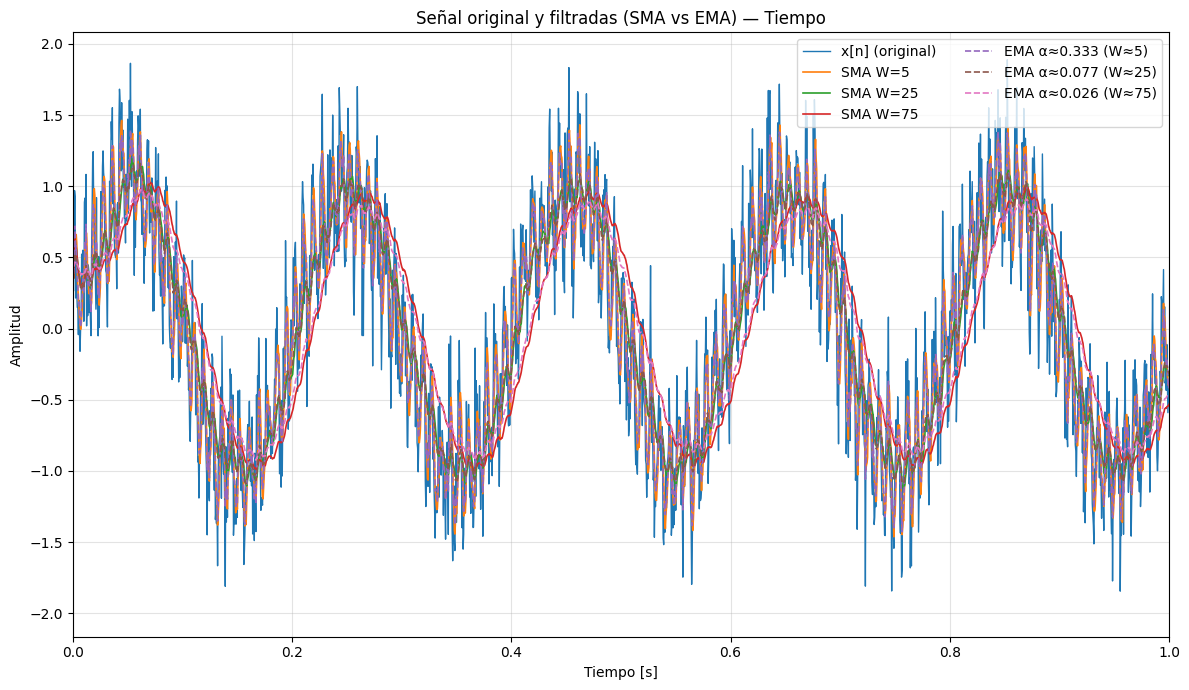

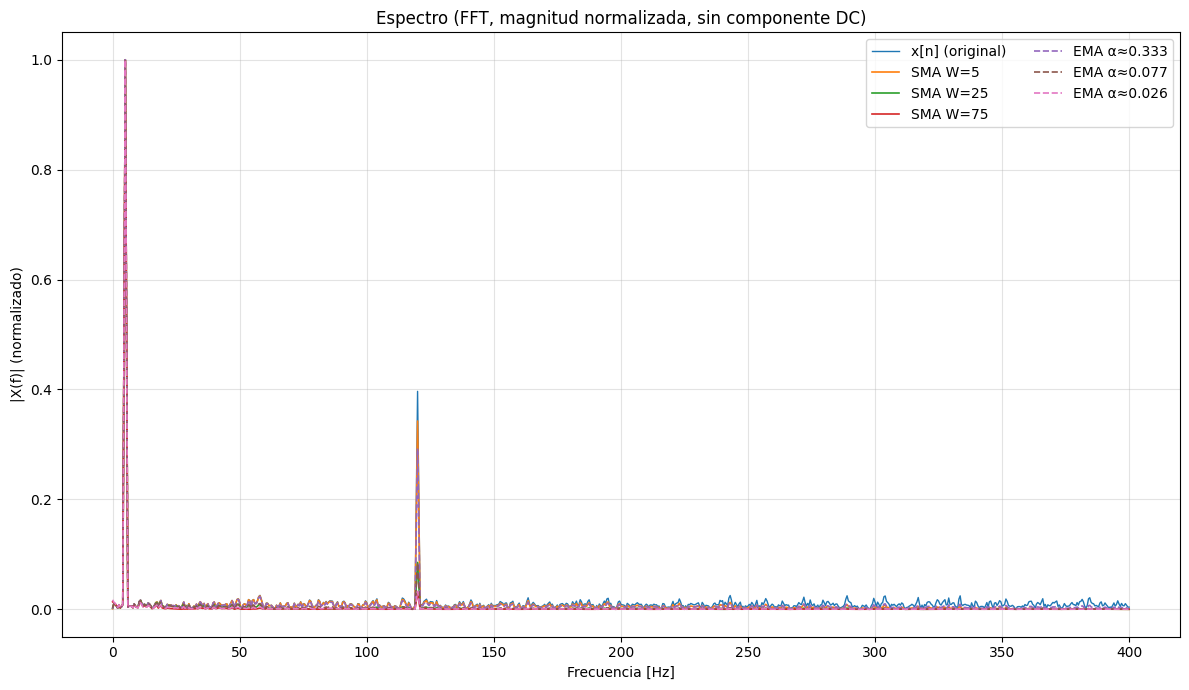

In [ ]:
# ============================================================
# Simple Moving Average (SMA) vs Exponential Moving Average (EMA)
# Google Colab
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Señal de prueba ----------
fs = 2000           # Hz
T  = 2.0            # s
t  = np.arange(0, T, 1/fs)

np.random.seed(0)
f1, A1 = 5,   1.0   # componente útil lenta
f2, A2 = 120, 0.4   # componente alta (a atenuar)
x = A1*np.sin(2*np.pi*f1*t) + A2*np.sin(2*np.pi*f2*t) + 0.25*np.random.randn(t.size)

# Tamaños de ventana a probar para SMA
W_list = [5, 25, 75]

# ---------- Filtros ----------
def sma_diff_eq(x, W):
    """
    Media móvil simple por ecuación en diferencia:
      y[n] = y[n-1] + (1/W) * (x[n] - x[n-W])
    Manejo del arranque: para n < W se usa el promedio de lo disponible.
    """
    N = x.size
    y = np.empty_like(x, dtype=float)
    acc = 0.0
    for n in range(N):
        acc += x[n]
        if n < W:
            y[n] = acc / (n+1)         # promedio parcial hasta completar W
        else:
            y[n] = y[n-1] + (x[n] - x[n-W]) / W
    return y

def ema(x, alpha):
    """
    Media móvil exponencial: y[n] = α x[n] + (1-α) y[n-1], y[0]=x[0]
    """
    y = np.empty_like(x, dtype=float)
    y[0] = x[0]
    for n in range(1, x.size):
        y[n] = alpha*x[n] + (1-alpha)*y[n-1]
    return y

def alpha_from_W(W):
    # Elección clásica que da suavizado parecido al de SMA(W)
    return 2.0 / (W + 1.0)

def fft_mag(x, fs, fmax=None, detrend=True):
    """
    Magnitud normalizada de la rFFT con ventana Hann y opción de quitar DC.
    """
    xw = x - x.mean() if detrend else x
    N = xw.size
    X = np.fft.rfft(xw * np.hanning(N))
    f = np.fft.rfftfreq(N, 1/fs)
    mag = np.abs(X)
    mag /= (mag.max() + 1e-12)
    if fmax is not None:
        m = f <= fmax
        f, mag = f[m], mag[m]
    return f, mag

# ---------- Cálculos ----------
sma = {W: sma_diff_eq(x, W) for W in W_list}
ema_out = {W: ema(x, alpha_from_W(W)) for W in W_list}

# ---------- Tiempo (superpuestas) ----------
plt.figure(figsize=(12, 7))
plt.plot(t, x, label="x[n] (original)", linewidth=1.0)
for W in W_list:
    plt.plot(t, sma[W], label=f"SMA W={W}", linewidth=1.2)
for W in W_list:
    a = alpha_from_W(W)
    plt.plot(t, ema_out[W], "--", label=f"EMA α≈{a:.3f} (W≈{W})", linewidth=1.2)
plt.xlim(0, 1.0)  # zoom para notar el suavizado
plt.grid(True, alpha=0.35)
plt.title("Señal original y filtradas (SMA vs EMA) — Tiempo")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.show()

# ---------- Espectro (FFT) ----------
plt.figure(figsize=(12, 7))
f, Mx = fft_mag(x, fs, fmax=400)
plt.plot(f, Mx, label="x[n] (original)", linewidth=1.0)
for W in W_list:
    fS, MS = fft_mag(sma[W], fs, fmax=400)
    plt.plot(fS, MS, label=f"SMA W={W}", linewidth=1.2)
for W in W_list:
    fE, ME = fft_mag(ema_out[W], fs, fmax=400)
    plt.plot(fE, ME, "--", label=f"EMA α≈{alpha_from_W(W):.3f}", linewidth=1.2)
plt.grid(True, alpha=0.35)
plt.title("Espectro (FFT, magnitud normalizada, sin componente DC)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("|X(f)| (normalizado)")
plt.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.show()


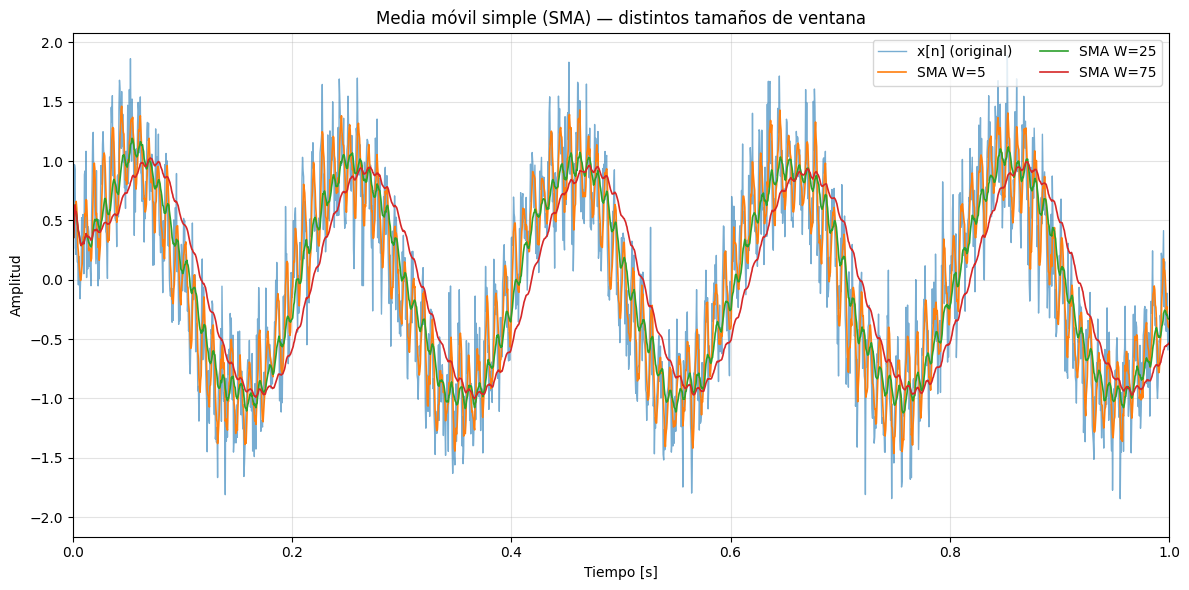

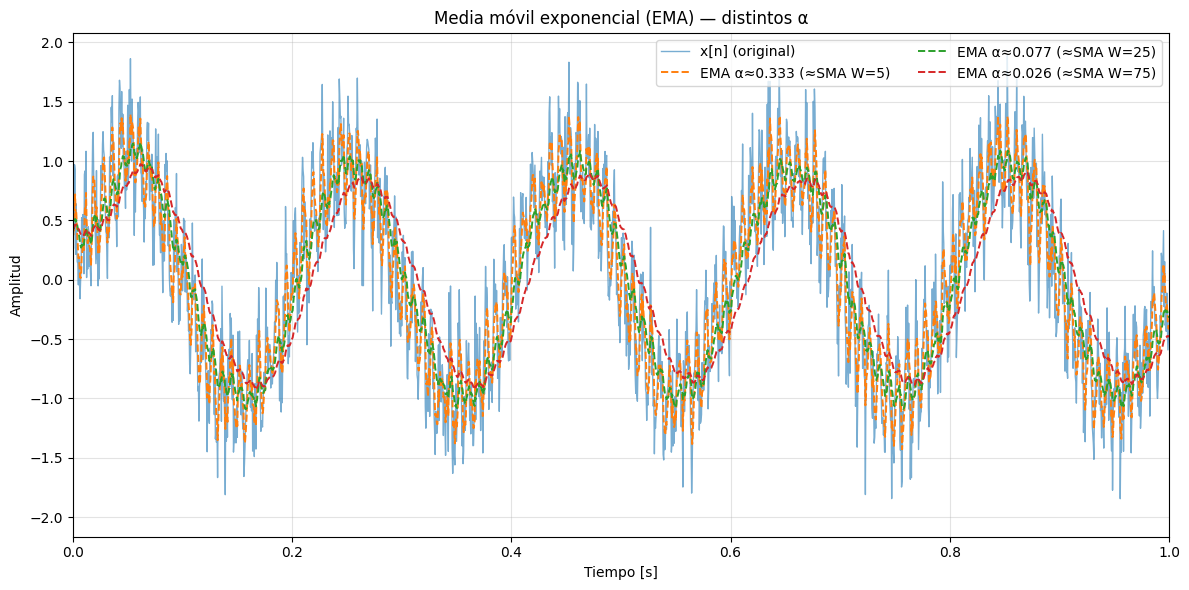

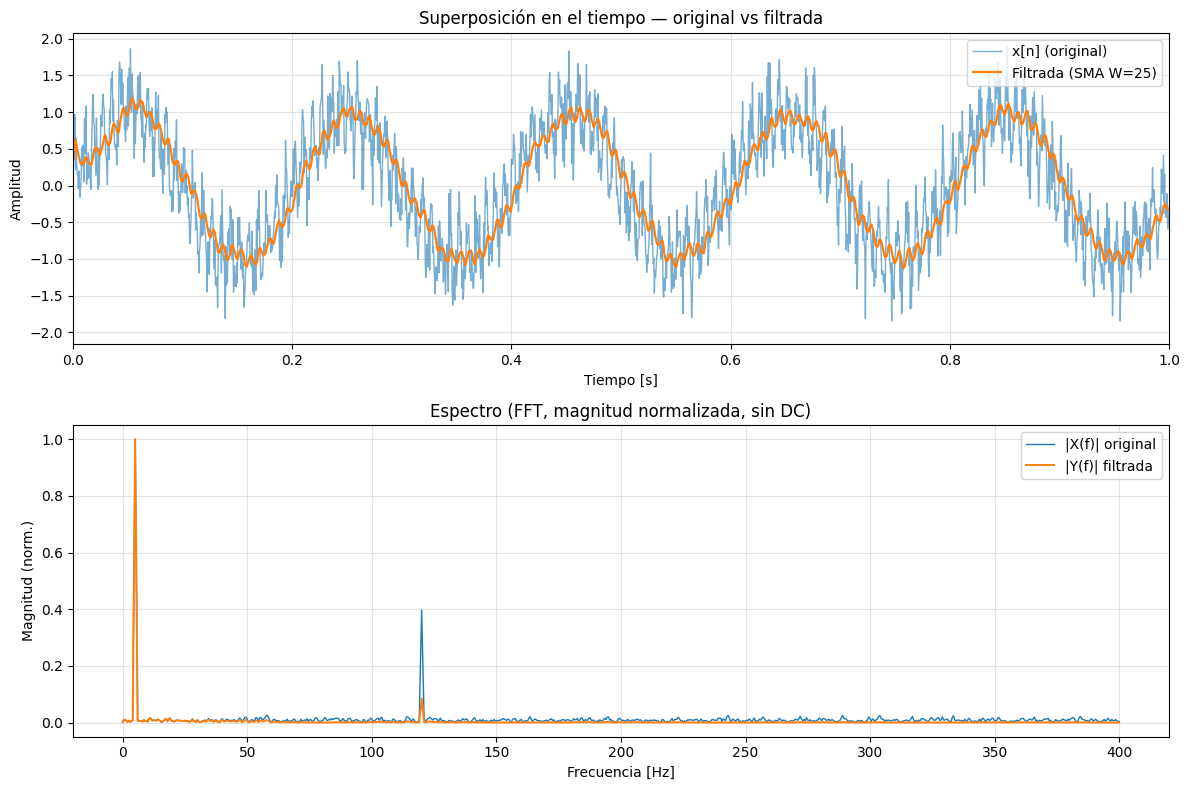

In [ ]:
# ============================================================
# SMA vs EMA — 3 gráficas (SMA, EMA, overlay + FFT)
# Google Colab
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# -------- Señal de prueba --------
fs = 2000          # Hz
T  = 2.0           # s
t  = np.arange(0, T, 1/fs)

np.random.seed(0)
f1, A1 = 5,   1.0  # componente baja (útil)
f2, A2 = 120, 0.4  # componente alta (a atenuar)
x = A1*np.sin(2*np.pi*f1*t) + A2*np.sin(2*np.pi*f2*t) + 0.25*np.random.randn(t.size)

# Ventanas y alfas a comparar
W_list = [5, 25, 75]                 # tamaños de ventana para SMA
alpha_from_W = lambda W: 2.0/(W+1.0) # mapeo clásico: EMA comparable a SMA(W)
alpha_list = [alpha_from_W(W) for W in W_list]

# -------- Filtros --------
def sma_diff_eq(x, W):
    """SMA por ecuación en diferencia con arranque correcto."""
    N = x.size
    y = np.empty_like(x, dtype=float)
    acc = 0.0
    for n in range(N):
        acc += x[n]
        if n < W:
            y[n] = acc/(n+1)               # promedio parcial hasta completar W
        else:
            y[n] = y[n-1] + (x[n]-x[n-W])/W
    return y

def ema(x, alpha):
    """EMA: y[n] = alpha*x[n] + (1-alpha)*y[n-1], y[0]=x[0]."""
    y = np.empty_like(x, dtype=float)
    y[0] = x[0]
    for n in range(1, x.size):
        y[n] = alpha*x[n] + (1-alpha)*y[n-1]
    return y

def fft_mag(x, fs, fmax=None, detrend=True):
    """Magnitud normalizada de rFFT con ventana Hann y sin DC (opcional)."""
    xw = x - x.mean() if detrend else x
    N  = xw.size
    X  = np.fft.rfft(xw * np.hanning(N))
    f  = np.fft.rfftfreq(N, 1/fs)
    M  = np.abs(X)
    M /= (M.max() + 1e-12)
    if fmax is not None:
        m = f <= fmax
        f, M = f[m], M[m]
    return f, M

# -------- Salidas --------
sma = {W: sma_diff_eq(x, W) for W in W_list}
ema_out = {a: ema(x, a) for a in alpha_list}

# ============================================================
# GRÁFICO 1 — SMA con distintos W
# ============================================================
plt.figure(figsize=(12, 6))
plt.plot(t, x, label="x[n] (original)", linewidth=1.0, alpha=0.6)
for W in W_list:
    plt.plot(t, sma[W], label=f"SMA W={W}", linewidth=1.2)
plt.xlim(0, 1.0)  # zoom 1 s para notar el suavizado
plt.grid(True, alpha=0.35)
plt.title("Media móvil simple (SMA) — distintos tamaños de ventana")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.show()

# ============================================================
# GRÁFICO 2 — EMA con distintos α
# ============================================================
plt.figure(figsize=(12, 6))
plt.plot(t, x, label="x[n] (original)", linewidth=1.0, alpha=0.6)
for a, W in zip(alpha_list, W_list):
    plt.plot(t, ema_out[a], "--", label=f"EMA α≈{a:.3f} (≈SMA W={W})", linewidth=1.4)
plt.xlim(0, 1.0)
plt.grid(True, alpha=0.35)
plt.title("Media móvil exponencial (EMA) — distintos α")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.show()

# ============================================================
# GRÁFICO 3 — Overlay (tiempo) + FFT (espectro)
# Elegí qué filtro comparar (acá usamos SMA W=25)
# ============================================================
W_pick = 25
y_pick = sma[W_pick]  # podés cambiar por ema_out[alpha_from_W(W_pick)]

fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# 3A) Tiempo superpuesto
axs[0].plot(t, x, label="x[n] (original)", linewidth=1.0, alpha=0.6)
axs[0].plot(t, y_pick, label=f"Filtrada (SMA W={W_pick})", linewidth=1.6)
axs[0].set_xlim(0, 1.0)
axs[0].grid(True, alpha=0.35)
axs[0].set_title("Superposición en el tiempo — original vs filtrada")
axs[0].set_xlabel("Tiempo [s]")
axs[0].set_ylabel("Amplitud")
axs[0].legend(loc="upper right")

# 3B) Espectro
f0, Mx = fft_mag(x, fs, fmax=400)
f1, My = fft_mag(y_pick, fs, fmax=400)
axs[1].plot(f0, Mx, label="|X(f)| original", linewidth=1.0)
axs[1].plot(f1, My, label="|Y(f)| filtrada", linewidth=1.4)
axs[1].grid(True, alpha=0.35)
axs[1].set_title("Espectro (FFT, magnitud normalizada, sin DC)")
axs[1].set_xlabel("Frecuencia [Hz]")
axs[1].set_ylabel("Magnitud (norm.)")
axs[1].legend(loc="upper right")

plt.tight_layout()
plt.show()
